## Обучаем первую модель на MNIST

План на сегодня: пишем первый пайплайн для обучения

1. Пытаемся понять, какие компоненты нам нужны для обучения любой модели
2. Выясняем, что многое уже есть в Pytorch
3. Собираем наш первый скрипт для обучения на датасете MNIST

### 1. Разбираемся с данными

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

#### 1.1. Организуем доступ к данным с `torch.utils.data.Dataset`

Датасет в pytorch - это объект класса, в котором реализовано два обязательных метода: `__getitem__(self, index: int)` (получение одиночного примера по индексу) и `__len__(self)` (получение общего количества примеров). Этих методов достаточно, чтобы разбивать датасет на минибатчи  - это работу делает класс `torch.utils.DataLoader` с помощью различных семплеров, с ними мы понакомимся позже

In [ ]:
import torch

torch.manual_seed(42)

In [ ]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, n: int) -> None:
        super().__init__()
        self.data = torch.arange(n * 3).view((n, 3))
        self.labels = torch.randint(0, 5, size=(n,))

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.data[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.data)


dataset = MyDataset(n=10)
print(dataset[0])
print(len(dataset))

(tensor([0, 1, 2]), tensor(2))
10


Итерируемся по датасету:

In [ ]:
dataset = MyDataset(10)
for i in range(len(dataset)):
    print(dataset[i])

(tensor([0, 1, 2]), tensor(3))
(tensor([3, 4, 5]), tensor(4))
(tensor([6, 7, 8]), tensor(0))
(tensor([ 9, 10, 11]), tensor(4))
(tensor([12, 13, 14]), tensor(1))
(tensor([15, 16, 17]), tensor(2))
(tensor([18, 19, 20]), tensor(0))
(tensor([21, 22, 23]), tensor(0))
(tensor([24, 25, 26]), tensor(2))
(tensor([27, 28, 29]), tensor(1))


#### 1.2. Пакуем данные в батчи с `torch.utils.data.Dataloader`

У `torch.utils.data.Dataloader` много аргументов, на практике чаще всего используются
- `dataset` - объект, поддерживающий методы `__getitem__` и `__len__` (вопрос: можно ли передать список? словарь? множество?)
- `batch_size` - размер мини-батча
- `shuffle` - нужно ли перетасовать индексы перед нарезкой на минибатчи (это всегда стоит делать с обучающими данными, почему?)
- `num_workers` - количество процессов, которые будут загружать данные - иногда позволяет ускорить обучение (подумайте, в каком случае?)

In [ ]:
from torch.utils.data import DataLoader

my_loader = DataLoader(
    dataset=dataset,
    batch_size=4,
    shuffle=True,
    # drop_last=
)

In [ ]:
for i, batch in enumerate(my_loader):
    x, y = batch
    if i == 0:
        print(x)
        print(y)

tensor([[24, 25, 26],
        [ 6,  7,  8],
        [21, 22, 23],
        [15, 16, 17]])
tensor([2, 0, 0, 2])


#### 1.3. Посмотрим на MNIST

- какие атрибуты есть у объекта `torchvision.datasets.MNIST`?
- как выглядит одно наблюдение?

In [ ]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),  # что это?
)
test_dataset = datasets.MNIST(
    "data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34336141.77it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1098796.25it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9345054.11it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3226715.58it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
isinstance(train_dataset, Dataset)

True

In [ ]:
x, y = train_dataset[0]
print(x.shape)
print(y)

torch.Size([1, 28, 28])
5


**Задание 1 (1 балл)**. Используя `matplotlib`, выведите по одному примеру изображения для всех классов

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


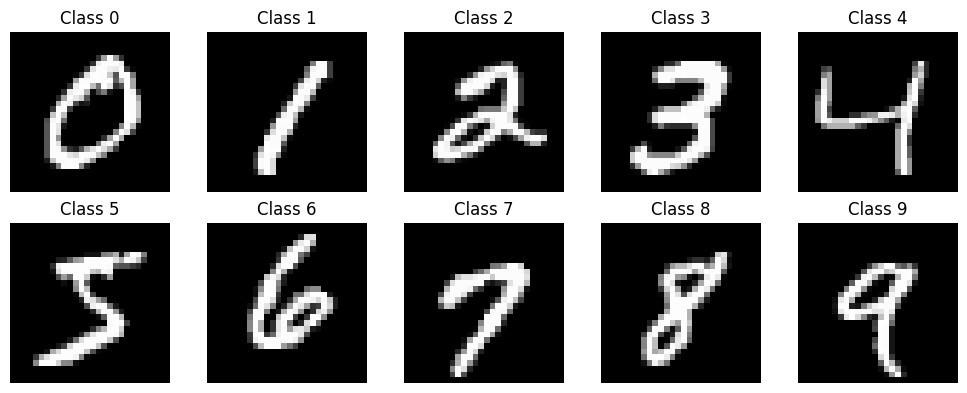

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist

# Загрузка данных MNIST
(train_images, train_labels), (_, _) = mnist.load_data()

# Создаем список для хранения примеров каждого класса
classes = np.unique(train_labels)
class_examples = {}

# Отбираем по одному примеру каждого класса
for label in classes:
    idx = np.where(train_labels == label)[0][0]
    class_examples[label] = train_images[idx]

# Выводим изображения
plt.figure(figsize=(10, 4))
for i, (label, image) in enumerate(class_examples.items()):
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Class {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Попробуем получить минибатч:

In [ ]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Что возвращает `iter()`?

In [ ]:
batch: tuple[torch.Tensor, torch.Tensor] = next(iter(train_loader))
x, y = batch
print(x.shape)
print(y.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


Со свёрточными сетями мы познакомимся позже, сейчас же мы будем экспериментировать с обычными полносвязными сетями, но для этого нам нужно будет преобразовать форму батча из `(batch_size, channels, width, height)` в `(batch_size, channels * width * height)`:

**Задание 2 (1 балл)**. Есть несколько способов изменить форму (shape) тензора. Приведите все знаковые вам способы привести батч с изображениями в форму `(batch_size, channels * width * height)`

In [ ]:
batch_size, channels, width, height = x.shape
input_dim = channels * width * height
"""
.view()
.reshape()
.flatten()
.permute()
.contiguous()
"""

'\n.view() \n.reshape() \n.flatten() \n.permute() \n.contiguous() \n'

Ура, с данными вроде разобрались! Теперь разберёмся с моделью

### 2. Реализуем модель с помощью `torch.nn.Module`

#### 2.1. Описываем параметры модели и прямой проход

Для простоты будем строить небольшую нейронку из двух полносвязных слоёв и `tanh` в качестве функции активации.

$\text{logits} = w_2^T(\tanh(w_1^T x + b_1)) + b_2$

Какие параметры должны быть в линейном слое?

In [ ]:
hidden_dim = 128  # размерность скрытого слоя
n_classes = 10

# первый слой
w1 = torch.randn((input_dim, hidden_dim), requires_grad=True)
b1 = torch.randn(hidden_dim, requires_grad=True)

# второй слой
w2 = torch.randn((hidden_dim, n_classes), requires_grad=True)
b2 = torch.randn(n_classes, requires_grad=True)

h = x.flatten(1) @ w1 + b1
print(h.grad_fn)
print(h.shape)

# применяем нелинейность перед применением следующего слоя
h = h.tanh()

h = h @ w2 + b2
print(h.grad_fn)
print(h.shape)

In [ ]:
h

Из этих выходных данных нам хотелось бы получить вероятностное распределение над возможными классами, то есть нужно как-то нормализовать эти активации, для этого обычно используется функция `softmax`:

In [ ]:
z = torch.randn(10)
torch.softmax(z, 0)
# zz = torch.exp(z) / torch.exp(z).sum()
# zz.sum()

tensor([0.0875, 0.1361, 0.3852, 0.0321, 0.1009, 0.1273, 0.0733, 0.0299, 0.0156,
        0.0121])

Применим к нашим данным:

In [ ]:
h.softmax(dim=1)

NameError: name 'h' is not defined

Обратите внимание: классы получились совсем не равновероятны, хотя мы ещё не учили модель. Подумайте, почему так произошло?
Подробнее это мы обсудим на следующей практике.

Параметры нашей модели находятся в глобальной области видимости. Решение - спрятать всё внутрь класса-наследника `torch.nn.Module`

#### 2.2. Реализуем двуслойный перцептрон как наследник `nn.Module`

**Задание 3 (1 балл)**. Прочитайте документацию к классам `torch.nn.Module` и `torch.nn.Parameter`. Почему при задании параметров модели не стоит их создавать просто как `torch.tensor(..., requires_grad=True)`?

In [ ]:
"""Использование torch.tensor(..., requires_grad=True) не регистрирует тензор как параметр модели.
Значит оптимизаторы и другие механизмы не будут знать,что этот тензор нужно обновлять во время обратного распространения."""

'Использование torch.tensor(..., requires_grad=True) не регистрирует тензор как параметр модели.\nЗначит оптимизаторы и другие механизмы не будут знать,что этот тензор нужно обновлять во время обратного распространения.'

**Задание 4 (1 балл)**. Чтобы сделать наш модуль рабочим, нужно определить два метода: `__init__` и `forward`. Реализуйте метод `forward`, который возвращает логиты, т. е. выход последнего линейного слоя без применения функции активации `softmax`

In [ ]:
class SimpleNet(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.b1 = torch.nn.Parameter(torch.randn(hidden_dim))

        self.w2 = torch.nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.b2 = torch.nn.Parameter(torch.randn(output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        hidden = torch.matmul(x, self.w1) + self.b1
        hidden = torch.relu(hidden)
        logits = torch.matmul(hidden, self.w2) + self.b2
        return logits

In [ ]:
model = SimpleNet(input_dim, hidden_dim, n_classes)
model(x).shape

torch.Size([32, 10])

Параметры модели:

In [ ]:
list(model.named_parameters())

[('w1',
  Parameter containing:
  tensor([[-0.4833,  1.1003,  1.6497,  ..., -0.4619,  0.3176,  0.3544],
          [ 0.1323, -0.3789, -0.2160,  ..., -0.4942,  0.5313,  0.0694],
          [-1.9792, -0.8956, -0.3710,  ..., -0.8225,  0.8167, -0.7712],
          ...,
          [-0.2524,  1.3724,  0.7869,  ..., -0.7087,  1.0261,  0.0431],
          [ 1.0059,  0.5968, -2.6199,  ...,  0.5565, -0.6058,  0.3181],
          [ 0.3067, -1.1977,  0.8383,  ...,  0.0406,  0.0630,  0.0855]],
         requires_grad=True)),
 ('b1',
  Parameter containing:
  tensor([ 1.1557e+00, -4.4822e-01,  1.9142e-01, -1.3616e+00,  7.1722e-01,
           6.6379e-01, -6.1405e-01,  1.3502e+00,  5.9717e-01, -1.1031e+00,
          -4.8588e-01, -1.4613e+00, -8.7228e-01,  8.9916e-01,  5.5902e-01,
          -1.4034e+00, -4.4950e-02,  2.7086e-02, -1.2089e+00, -2.0392e-01,
          -4.3619e-01, -4.1470e-04,  1.7490e+00, -1.6310e-01, -1.5554e+00,
          -1.2879e+00, -1.5209e+00, -8.8056e-01,  1.8646e-02,  6.7518e-01,
       

Вручную обновлять значения многих параметров очень неудобно. К счастью, за нас это сделает оптимизатор

In [ ]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


#### 2.1. Считаем ошибку и градиенты на одном минибатче

In [ ]:
# получим предсказания и посчитаем ошибку
predictions = model.forward(x)
loss = torch.nn.functional.cross_entropy(predictions, y)
print(loss)
# рассчитаем градиенты и обновим параметры
loss.backward()
optimizer.step()

# не забудем почистить градиенты, мы не хотим их накапливать
optimizer.zero_grad()

tensor(378.5316, grad_fn=<NllLossBackward0>)


**Задание 5 (1 балл)**: Посчитайте значение перекрёстной энтропии самостоятельно по формуле, сверьтесь с результатом выше

In [ ]:
# посчитайте ce_loss на основе значений переменных `predictions` и `y`
ce_loss = torch.tensor(0.0)
predictions = predictions.softmax(dim=1)
for i in range(batch_size):
    for class_num in range(10):
        if y[i] == class_num:
            ce_loss -= predictions[i][class_num].log()
assert torch.allclose(ce_loss, loss), f"{ce_loss} != {loss}"

AssertionError: 9.126385688781738 != 378.5315856933594

### 3. Обучение

#### 3.1. Шаг обучения: что мы делаем с каждым минибатчем данных

In [ ]:
def training_step(
    batch: tuple[torch.Tensor, torch.Tensor],
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> tuple[torch.Tensor, torch.Tensor]:
    # прогоняем батч через модель
    x, y = batch
    predictions = model(x)
    # оцениваем значение ошибки
    loss = torch.nn.functional.cross_entropy(predictions, y)
    # обновляем параметры
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # возвращаем значение функции ошибки для логирования
    return loss, predictions

Для тестовых батчей нам не нужны градиенты, поэтому расчёты делаем внутри контекста `torch.no_grad`

In [ ]:
def test_step(
    batch: tuple[torch.Tensor, torch.Tensor], model: torch.nn.Module
) -> tuple[torch.Tensor, torch.Tensor]:
    x, y = batch
    with torch.no_grad():
        predictions = model(x)
        # оцениваем значение ошибки
        loss = torch.nn.functional.cross_entropy(predictions, y)
    return loss, predictions

#### 3.2. А теперь: что мы хотим делать в каждой эпохе?

**Задание 6 (2 балла)**: Напишите функцию для запуска одной эпохи (обучающей или тестовой), которая итерируется по минибатчам, обрабатывает их и в конце выводит среднюю ошибку и точность классификации. Запустите обучение на 10-15 эпох, добейтесь точности более 92% на тестовой выборке.

In [ ]:
def run_epoch(
    is_train: bool,
    dataloader: DataLoader,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> None:
    # ВАШ ХОД

    for batch in dataloader:
        ...

    epoch_loss = ...
    accuracy = ...
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

Создадим модель, оптимизатор и загрузчики данных и запустим обучение:

In [ ]:
n_epochs = 15
for i in range(n_epochs):
    print(f"Epoch {i} train:")
    run_epoch(True, train_loader, model, optimizer)
    print(f"Epoch {i} test:")
    run_epoch(False, test_loader, model, optimizer)